# Experimenting with xarray-simlab

Following tutorial material in [xarray-simlab docs](https://xarray-simlab.readthedocs.io/en/latest/create_model.html) to try to set up a simple EBM driven by xarray-simlab.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xsimlab as xs

Try to repeat the simple diffusion example at https://brian-rose.github.io/ClimateLaboratoryBook/courseware/numerical-diffusion.html
with the FTCS scheme.

The equation to be solved is

$$ \frac{\partial u}{\partial t} = K \frac{\partial^2 u}{\partial x^2} $$

with boundary conditions flux = 0 at boundaries.

In [2]:
@xs.process
class UniformGrid1D:
    """Create a 1-dimensional, equally spaced grid."""

    spacing = xs.variable(description="uniform spacing", static=True)
    length = xs.variable(description="total length", static=True)
    x = xs.index(dims="x")

    def initialize(self):
        self.x = np.arange(0, self.length, self.spacing)

In [3]:
@xs.process
class ProfileU:
    """Compute the evolution of the profile of quantity `u`."""

    u_vars = xs.group("u_vars")
    u = xs.variable(
        dims="x", intent="inout", description="quantity u", attrs={"units": "m"}
    )

    def run_step(self):
        self._delta_u = sum((v for v in self.u_vars))

    def finalize_step(self):
        self.u += self._delta_u

In [57]:
@xs.process
class Diffusion:
    """Diffusion using FTCS scheme

    """

    u = xs.variable(dims=[(), "x"], description="scalar")
    grid_spacing = xs.foreign(UniformGrid1D, "spacing")
    u = xs.foreign(ProfileU, "u")
    u_diffused = xs.variable(dims="x", intent="out", groups="u_vars")
    K = xs.variable(dims=[(), "x"], description="diffusion coefficient")

    def diffusive_flux(self, u, deltax, K=1):
        #  Take the finite difference
        F = np.diff(u)/deltax
        #  add a zero as the first element (no flux on boundary)
        F = np.insert(F, 0, 0.)
        #  add another zero as the last element (no flux on boundary)
        F = np.append(F, 0.)
        #  flux is DOWN gradient, proportional to D
        return -K*F
    
    def diffusion(self, u, deltax, K=1):
        #  compute flux
        F = self.diffusive_flux(u, deltax, K)
        #  take convergence of flux
        return -np.diff(F) / deltax
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        deltax = self.grid_spacing
        dudt = self.diffusion(self.u, deltax, self.K)
        self.u_diffused = self.u + dt * dudt


In [58]:
@xs.process
class InitUGauss:
    """Initialize `u` profile using a Gaussian pulse."""

    loc = xs.variable(description="location of initial pulse", static=True)
    scale = xs.variable(description="scale of initial pulse", static=True)
    x = xs.foreign(UniformGrid1D, "x")
    u = xs.foreign(ProfileU, "u", intent="out")

    def initialize(self):
        self.u = np.exp(-1 / self.scale ** 2 * (self.x - self.loc) ** 2)

In [59]:
diff_model = xs.Model(
    {
        "grid": UniformGrid1D,
        "profile": ProfileU,
        "init": InitUGauss,
        "diffusion": Diffusion,
    }
)

In [60]:
diff_model

<xsimlab.Model (4 processes, 5 inputs)>
grid
    spacing     [in] uniform spacing
    length      [in] total length
init
    loc         [in] location of initial pulse
    scale       [in] scale of initial pulse
diffusion
    K           [in] () or ('x',) diffusion coefficient
profile

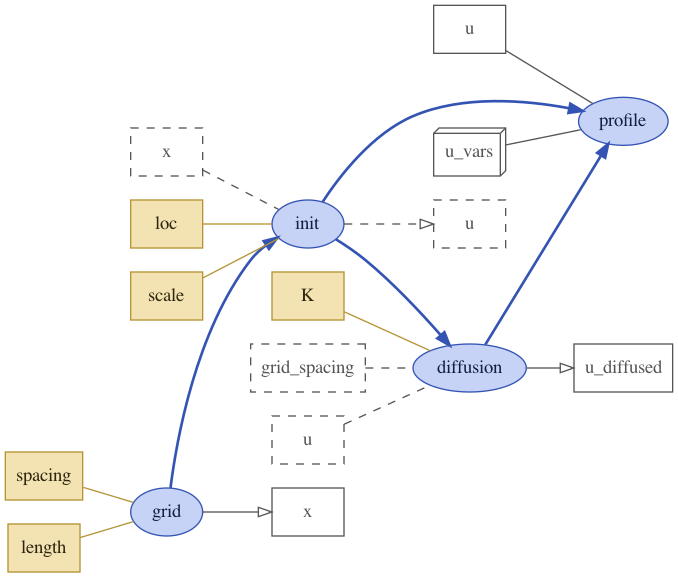

In [61]:
diff_model.visualize(show_inputs=True, show_variables=True)

In [79]:
in_ds = xs.create_setup(
            model=diff_model,
            clocks={
               'time': np.linspace(0., 0.01, 101),
               'otime': [0, 0.005, 0.01]
                   },
            master_clock='time',
            input_vars={
                'grid': {'length': 1.5, 'spacing': 0.01},
                'init': {'loc': 0.3, 'scale': 0.1},
                'diffusion__K': 1.
                       },
            output_vars={
               'profile__u': 'otime'
                        }
            )

In [80]:
in_ds

<xarray.Dataset>
Dimensions:        (otime: 3, time: 101)
Coordinates:
  * time           (time) float64 0.0 0.0001 0.0002 ... 0.0098 0.0099 0.01
  * otime          (otime) float64 0.0 0.005 0.01
Data variables:
    grid__length   float64 1.5
    grid__spacing  float64 0.01
    init__loc      float64 0.3
    init__scale    float64 0.1
    diffusion__K   float64 1.0

In [81]:
out_ds = in_ds.xsimlab.run(model=diff_model)

In [82]:
out_ds

<xarray.Dataset>
Dimensions:        (otime: 3, time: 101, x: 150)
Coordinates:
  * otime          (otime) float64 0.0 0.005 0.01
  * time           (time) float64 0.0 0.0001 0.0002 ... 0.0098 0.0099 0.01
  * x              (x) float64 0.0 0.01 0.02 0.03 0.04 ... 1.46 1.47 1.48 1.49
Data variables:
    diffusion__K   float64 1.0
    grid__length   float64 1.5
    grid__spacing  float64 0.01
    init__loc      float64 0.3
    init__scale    float64 0.1
    profile__u     (otime, x) float64 0.0001234 0.0002226 ... 1.901e+08 1e+08

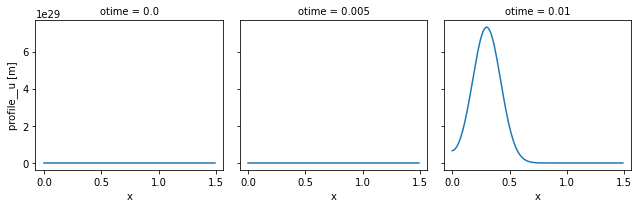

In [83]:
out_ds.profile__u.plot(col='otime', figsize=(9, 3));